In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append('../')
import emissions_model
from emissions_model import BitRobotEmissionsModel

import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
model = BitRobotEmissionsModel(
    initial_supply=0,
    team_allocation=260_000_000,
    investor_allocation=260_000_000,
    dao_allocation=480_000_000,
    dao_initial_liquidity=50_000_000,
    dao_target_48m=480_000_000,
    fixed_emissions_target=272_320_900,
    team_cliff_months=12,
    team_vesting_months=24,
    dao_vesting_months=48,
    t_burn=48,
    burn_emission_factor=0.9,
    burn_coefficient=1000000,
    burn_lookback_months=12,
    burn_volatility=0.01,
    burn_pattern="logarithmic",
    simulation_months=48*2
)

# Run the simulation
model.run_simulation()

In [5]:
results_df = model.get_results_dataframe()
results_df.head()

,Month,Team Vesting,Team Vested,Investor Vesting,Investor Vested,DAO Vesting,DAO Vested,Emissions,Burn,Circulating Supply,Total Supply,Team Contribution,Investor Contribution,DAO Contribution,Emissions Contribution
0,0,0.0,0.0,0.0,0.0,5.000000e+07,5.000000e+07,0.000000e+00,0.000000e+00,5.000000e+07,0.000000e+00,0.0,0.0,5.000000e+07,0.000000e+00
1,1,0.0,0.0,0.0,0.0,8.958333e+06,5.895833e+07,5.673352e+06,6.965901e+05,6.393510e+07,5.673352e+06,0.0,0.0,5.895833e+07,4.976762e+06
2,2,0.0,0.0,0.0,0.0,8.958333e+06,6.791667e+07,5.673352e+06,1.097093e+06,7.746969e+07,1.134670e+07,0.0,0.0,6.791667e+07,9.553021e+06
3,3,0.0,0.0,0.0,0.0,8.958333e+06,7.687500e+07,5.673352e+06,1.395273e+06,9.070610e+07,1.702006e+07,0.0,0.0,7.687500e+07,1.383110e+07
4,4,0.0,0.0,0.0,0.0,8.958333e+06,8.583333e+07,5.673352e+06,1.633950e+06,1.037038e+08,2.269341e+07,0.0,0.0,8.583333e+07,1.787050e+07


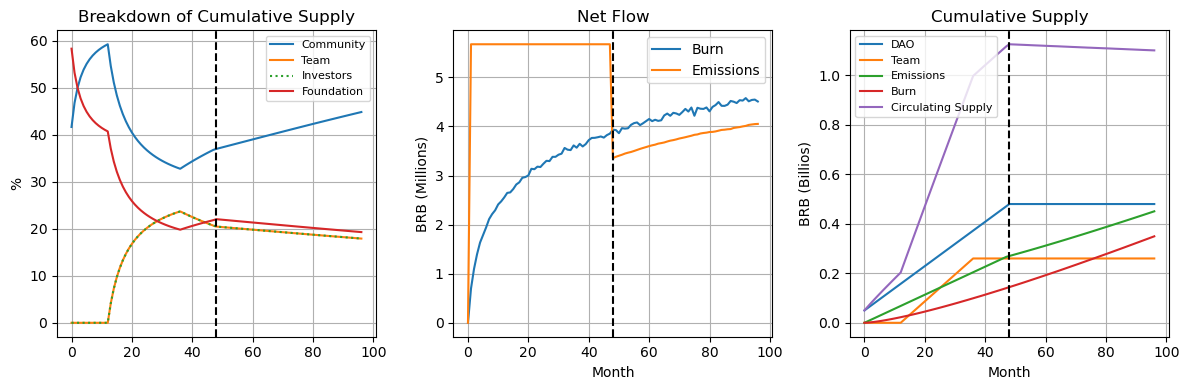

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 4))

axx = ax[0]
dao_community_portion = 20.0/48.0
community_portion = results_df['DAO Vested']*dao_community_portion + results_df['Emissions'].cumsum()
team_portion = results_df['Team Vested']
investor_portion = results_df['Investor Vested']
dao_team_portion = results_df['DAO Vested']*(1-dao_community_portion)
sum_val = community_portion + team_portion + dao_team_portion + investor_portion
# plot each component as a percentage of the total supply
axx.plot(results_df['Month'], community_portion/sum_val*100, label='Community')
axx.plot(results_df['Month'], team_portion/sum_val*100, label='Team')
axx.plot(results_df['Month'], investor_portion/sum_val*100, label='Investors', linestyle=':')
# Split Team --> Team + Investors
axx.plot(results_df['Month'], dao_team_portion/sum_val*100, label='Foundation')
axx.axvline(x=48, color='black', linestyle='--')
axx.legend(fontsize=8)
axx.set_ylabel('%')
axx.set_title('Breakdown of Cumulative Supply')
axx.grid()

axx = ax[1]
axx.plot(results_df['Month'], results_df['Burn']/1e6, label='Burn')
axx.plot(results_df['Month'], results_df['Emissions']/1e6, label='Emissions')
axx.axvline(x=48, color='black', linestyle='--')
axx.legend()
axx.set_title('Net Flow')
axx.set_xlabel('Month')
axx.set_ylabel('BRB (Millions)')
axx.grid()

axx = ax[2]
axx.plot(results_df['Month'], results_df['DAO Vested']/1e9, label='DAO')
axx.plot(results_df['Month'], results_df['Team Vested']/1e9, label='Team')
axx.plot(results_df['Month'], results_df['Emissions'].cumsum()/1e9, label='Emissions')
axx.plot(results_df['Month'], results_df['Burn'].cumsum()/1e9, label='Burn')
axx.plot(results_df['Month'], results_df['Circulating Supply']/1e9, label='Circulating Supply')
axx.axvline(x=48, color='black', linestyle='--')
# axx.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axx.legend(fontsize=8)
axx.set_title('Cumulative Supply')
axx.set_xlabel('Month')
axx.set_ylabel('BRB (Billios)')
axx.grid()


plt.tight_layout()
plt.savefig('supply_breakdown.png')

In [7]:
results_df.to_csv('results_df.csv', index=False)

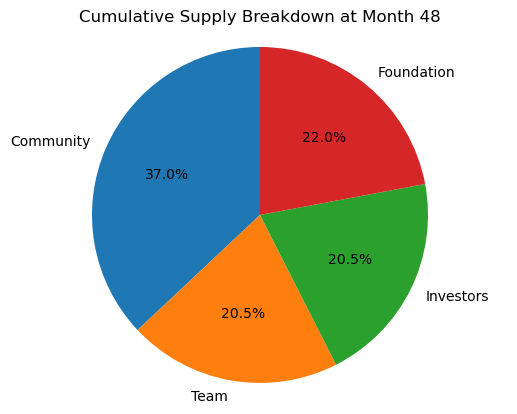

In [10]:
# Define the target month
target_month = 48

# Get the row for the target month
month_data = results_df[results_df['Month'] == target_month].iloc[0]

# Calculate the cumulative supply for each component
# These components should match the ones used in your line plot for the breakdown
dao_community_portion = 20.0 / 48.0
community_supply = month_data['DAO Vested'] * dao_community_portion + results_df['Emissions'].cumsum()[target_month]
team_supply = month_data['Team Vested']
investor_supply = month_data['Investor Vested']
dao_team_supply = month_data['DAO Vested'] * (1 - dao_community_portion)

# Create labels and sizes for the pie chart
labels = ['Community', 'Team', 'Investors', 'Foundation']
sizes = [community_supply, team_supply, investor_supply, dao_team_supply]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title(f'Cumulative Supply Breakdown at Month {target_month}')
# plt.show()
plt.savefig('pie-chart.png', dpi=300)